<font style='font-size:1.5em'>**NLTK Portion of the Project for News**</font>

**Author: Sentipedia**  

**Course: DS105L Project** 

---


## Import

### Importing Libraries 

In [ ]:
# importing libraries for web scrapping and API acess
import requests
from bs4 import BeautifulSoup

# importing libraries for dataframes 
import pandas as pd
import numpy as np

# importing libraries for plots 
from plotnine import *

# importing libraries for ploting networks
import networkx as nx
import matplotlib.pyplot as plt

# import language model 
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, ne_chunk

# downloading NLTK analyzers 
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('maxent_ne_chunker')
nltk.download('words')

# import libraries for plotnine
from plotnine import *

# import ggthemes
from plotnine.themes import theme_bw
import matplotlib.font_manager as fm

# Data

### Cleaing the Data

In [14]:
# dataframe with all news article on Brexit found in Reddit (data already cleaned)
df_news = pd.read_csv('news_full.csv', usecols = ['date_utc', 'title'], error_bad_lines=False, sep=';')

/var/folders/rq/hq1qw43s0zn29y7r6jj2h7h40000gn/T/ipykernel_30320/2270920396.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.




# Initializing NLTK Tools

In [15]:
# define lemmatizer, stop words and analyzer for nltk
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
analyzer = SentimentIntensityAnalyzer()

# Basic Sentiment Analysis Using Vader

### Vader with All Comments

In [16]:
# looking at sentiment scores for the full dataset
df_news_nltk = df_news.copy()

# define function to preprocess text
def text_preprocess(comment):
    try:
        # tokenize comments and preprocess text for sentiment analysis
        preprocessed_tokens = [word.lower() for word in word_tokenize(comment)]        
        preprocessed_tokens = [word for word in preprocessed_tokens if word not in stop_words]        
        preprocessed_tokens = [lemmatizer.lemmatize(word) for word in preprocessed_tokens]        
        preprocessed_tokens = [word for word in preprocessed_tokens if (len(word) > 1) and (word.isalpha()) and (word.isalnum())]
        return preprocessed_tokens
    except:
        return None

# define function to get sentiment scores
def get_score_nltk(tokens):
    try:
        # use sentiment analyzer from NLTK to get sentiment scores
        preprocessed_text = ' '.join(tokens)
        sentiment_scores = analyzer.polarity_scores(preprocessed_text)
        return sentiment_scores['compound']
    except:
        return None

In [18]:
# apply functions to get sentiment scores
df_news['tokens'] = df_news['title'].apply(text_preprocess)
df_news['score'] = df_news['tokens'].apply(get_score_nltk)
df_news

,date_utc,title,tokens,score
0,2020-12-26,Its time to leave the word Brexit behind an...,"[time, leave, word, behind, hold, government, ...",-0.0516
1,2018-06-11,70% of young Scots believe Brexit vote was a '...,"[young, scot, believe, brexit, vote, result]",0.0000
2,2019-04-14,Judge orders Ukip to reveal Brexit referendum ...,"[judge, order, ukip, reveal, brexit, referendu...",0.0000
3,2019-10-20,"New Post-Brexit TV Show - ""A Place in the Shit...","[new, tv, show, place, shit, daytime, show, su...",-0.6249
4,2019-05-22,Nigel Farage 'stuck on Brexit bus due to peopl...,"[nigel, farage, brexit, bus, due, people, arme...",0.0000
...,...,...,...,...
150,2019-11-15,UK prime minister withholding report on Russia...,"[uk, prime, minister, withholding, report, rus...",0.0000
151,2018-09-20,Emmanuel Macron calls Brexit campaign leaders ...,"[emmanuel, macron, call, brexit, campaign, lea...",-0.4767
152,2020-10-11,Brexit: Anger as ministers use obscure rule to...,"[brexit, anger, minister, use, obscure, rule, ...",-0.8271
153,2018-05-31,Anger among Brits in France after Brexit champ...,"[anger, among, brit, france, brexit, champion,...",-0.6808


# Sentiment Over Time 

### Sentiment Over Time for All Comments

findfont: Font family ['Mono'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Mono'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Mono'] not found. Falling back to DejaVu Sans.


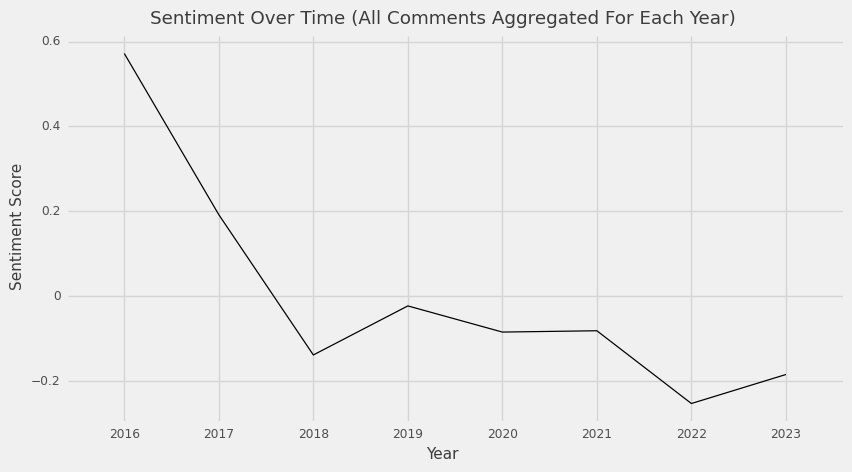

<ggplot: (8790030447613)>

In [20]:
df_news['date_utc'] = pd.to_datetime(df_news['date_utc'])
df_news['year'] = df_news['date_utc'].dt.to_period('Y')
df_avg = df_news.groupby('year')['score'].mean().reset_index()

plot = (
    ggplot(df_avg, aes(x='year', y='score', group = 1)) +
    geom_line() +
    xlab('Year') +
    ylab('Sentiment Score') +
    ggtitle('Sentiment Over Time (All Comments Aggregated For Each Year)') + 
    theme_538(base_family = 'Mono') +
    theme(figure_size=(10, 5))
)

plot


# Extracting Themes from Comments with Positive/Negative Sentiment

### Positive/Negative Sentiment for All Comments

In [22]:
# define function to get all nouns from tokens 
def get_nouns(tokens):
    try:
        nouns = [word for (word, pos) in pos_tag(tokens) if (pos and pos.startswith('N'))]
        return nouns
    except:
        return None

In [23]:
# apply functions to get nouns, adjectives and verbs tokens
df_news['nouns'] = df_news['tokens'].apply(get_nouns)

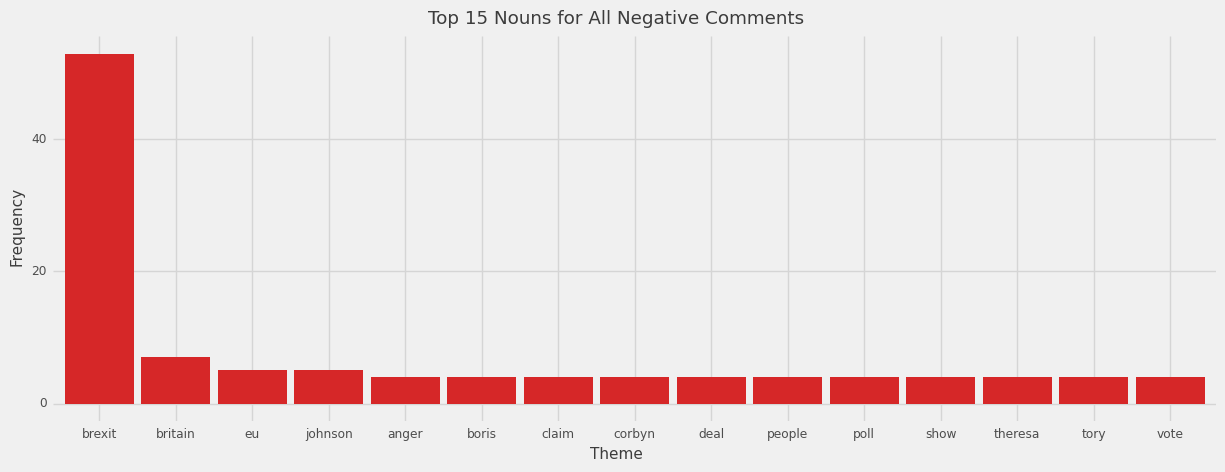

<ggplot: (8789979115767)>

In [31]:
# identify nouns of negative comments
negative_full_nouns = []
negative_full_nouns_series = df_news.loc[df_news['score'] < 0, 'nouns']

for value in negative_full_nouns_series: 
    for word in value:
        negative_full_nouns.append(word)

temp = pd.DataFrame({'theme': negative_full_nouns})
frequency = temp['theme'].value_counts().reset_index()
frequency.columns = ['theme', 'count']
top_15 = frequency.head(15)

# plot top 15 nouns for negative comments
plot = (
    ggplot(data=top_15) +
    aes(x='reorder(theme, -count)', y='count') +
    geom_bar(stat='identity', fill = '#d62728') +
    xlab('Theme') +
    ylab('Frequency') +
    ggtitle('Top 15 Nouns for All Negative Comments') + 
    theme_538(base_family = 'Mono') +
    theme(figure_size=(15, 5))
)

plot


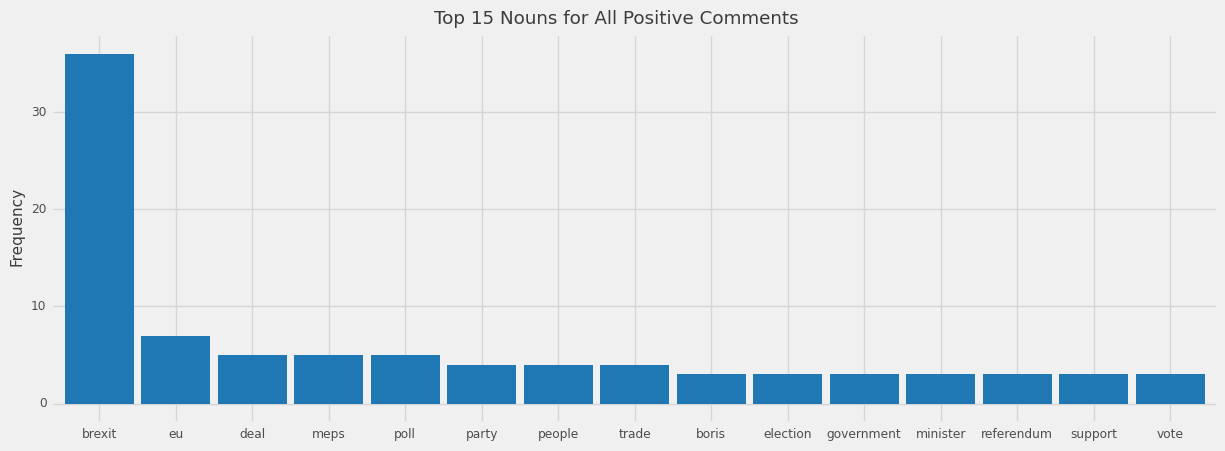

<ggplot: (8790032431101)>

In [33]:
# identify nouns of positive comments
positive_full_nouns = []
positive_full_nouns_series = df_news.loc[df_news['score'] > 0, 'nouns']

for value in positive_full_nouns_series:
    for word in value:
        positive_full_nouns.append(word)

temp = pd.DataFrame({'theme': positive_full_nouns})
frequency = temp['theme'].value_counts().reset_index()
frequency.columns = ['theme', 'count']
top_15 = frequency.head(15)

# plot top 15 nouns for negative comments
plot = (
    ggplot(data=top_15) +
    aes(x='reorder(theme, -count)', y='count') +
    geom_bar(stat='identity', fill = '#1f77b4') +
    xlab('') +
    ylab('Frequency') +
    ggtitle('Top 15 Nouns for All Positive Comments') + 
    theme_538(base_family = 'Mono') +
    theme(figure_size=(15, 5))
)

plot